## Anomaly Detection methods
Highly imbelenced time-series data can be difficult for the standard models, because the low density of error terms in the specific point of the timeline does not allow the standard oversampling technique to be used. In such cases, anomaly detection could be a promising improvement in detecting and predicting errors.

The performance of i.e.: IsolationForest has not proven this theory in the time series assessment. The following methods though could still improve the performance: Autoencoders, LSTM models.

### Conclusion
Autoencoder and LSTM models are performing quite reliable. The combination of these models will provide an adequate performance for the final product

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from src.visualisations import time_series_error_by_sensor, show_anomaly_distribution
from src.data_transformations import standardise
from src.anomaly_detection import detect_anomalies, create_autoencoder, create_lstm_autoencoder

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_parquet("data/clean/sensor_clean.pqt")

In [3]:
# Define the metric columns
metric_columns = [
    'sensor_00',
    'sensor_04',
    'sensor_10',
    'sensor_06',
    'sensor_11',
    'sensor_07',
    'sensor_02',
]

In [4]:
df = standardise(df,metric_columns)
pca = PCA(n_components=0.99)  # Retain 95% of variance
sensor_data_pca = pca.fit_transform(df[metric_columns])

In [5]:
# Create an error dataset for reference check
df_error = df[df['machine_status_code'] == 1]
df_recovery = df[df['machine_status_code'] == 2]

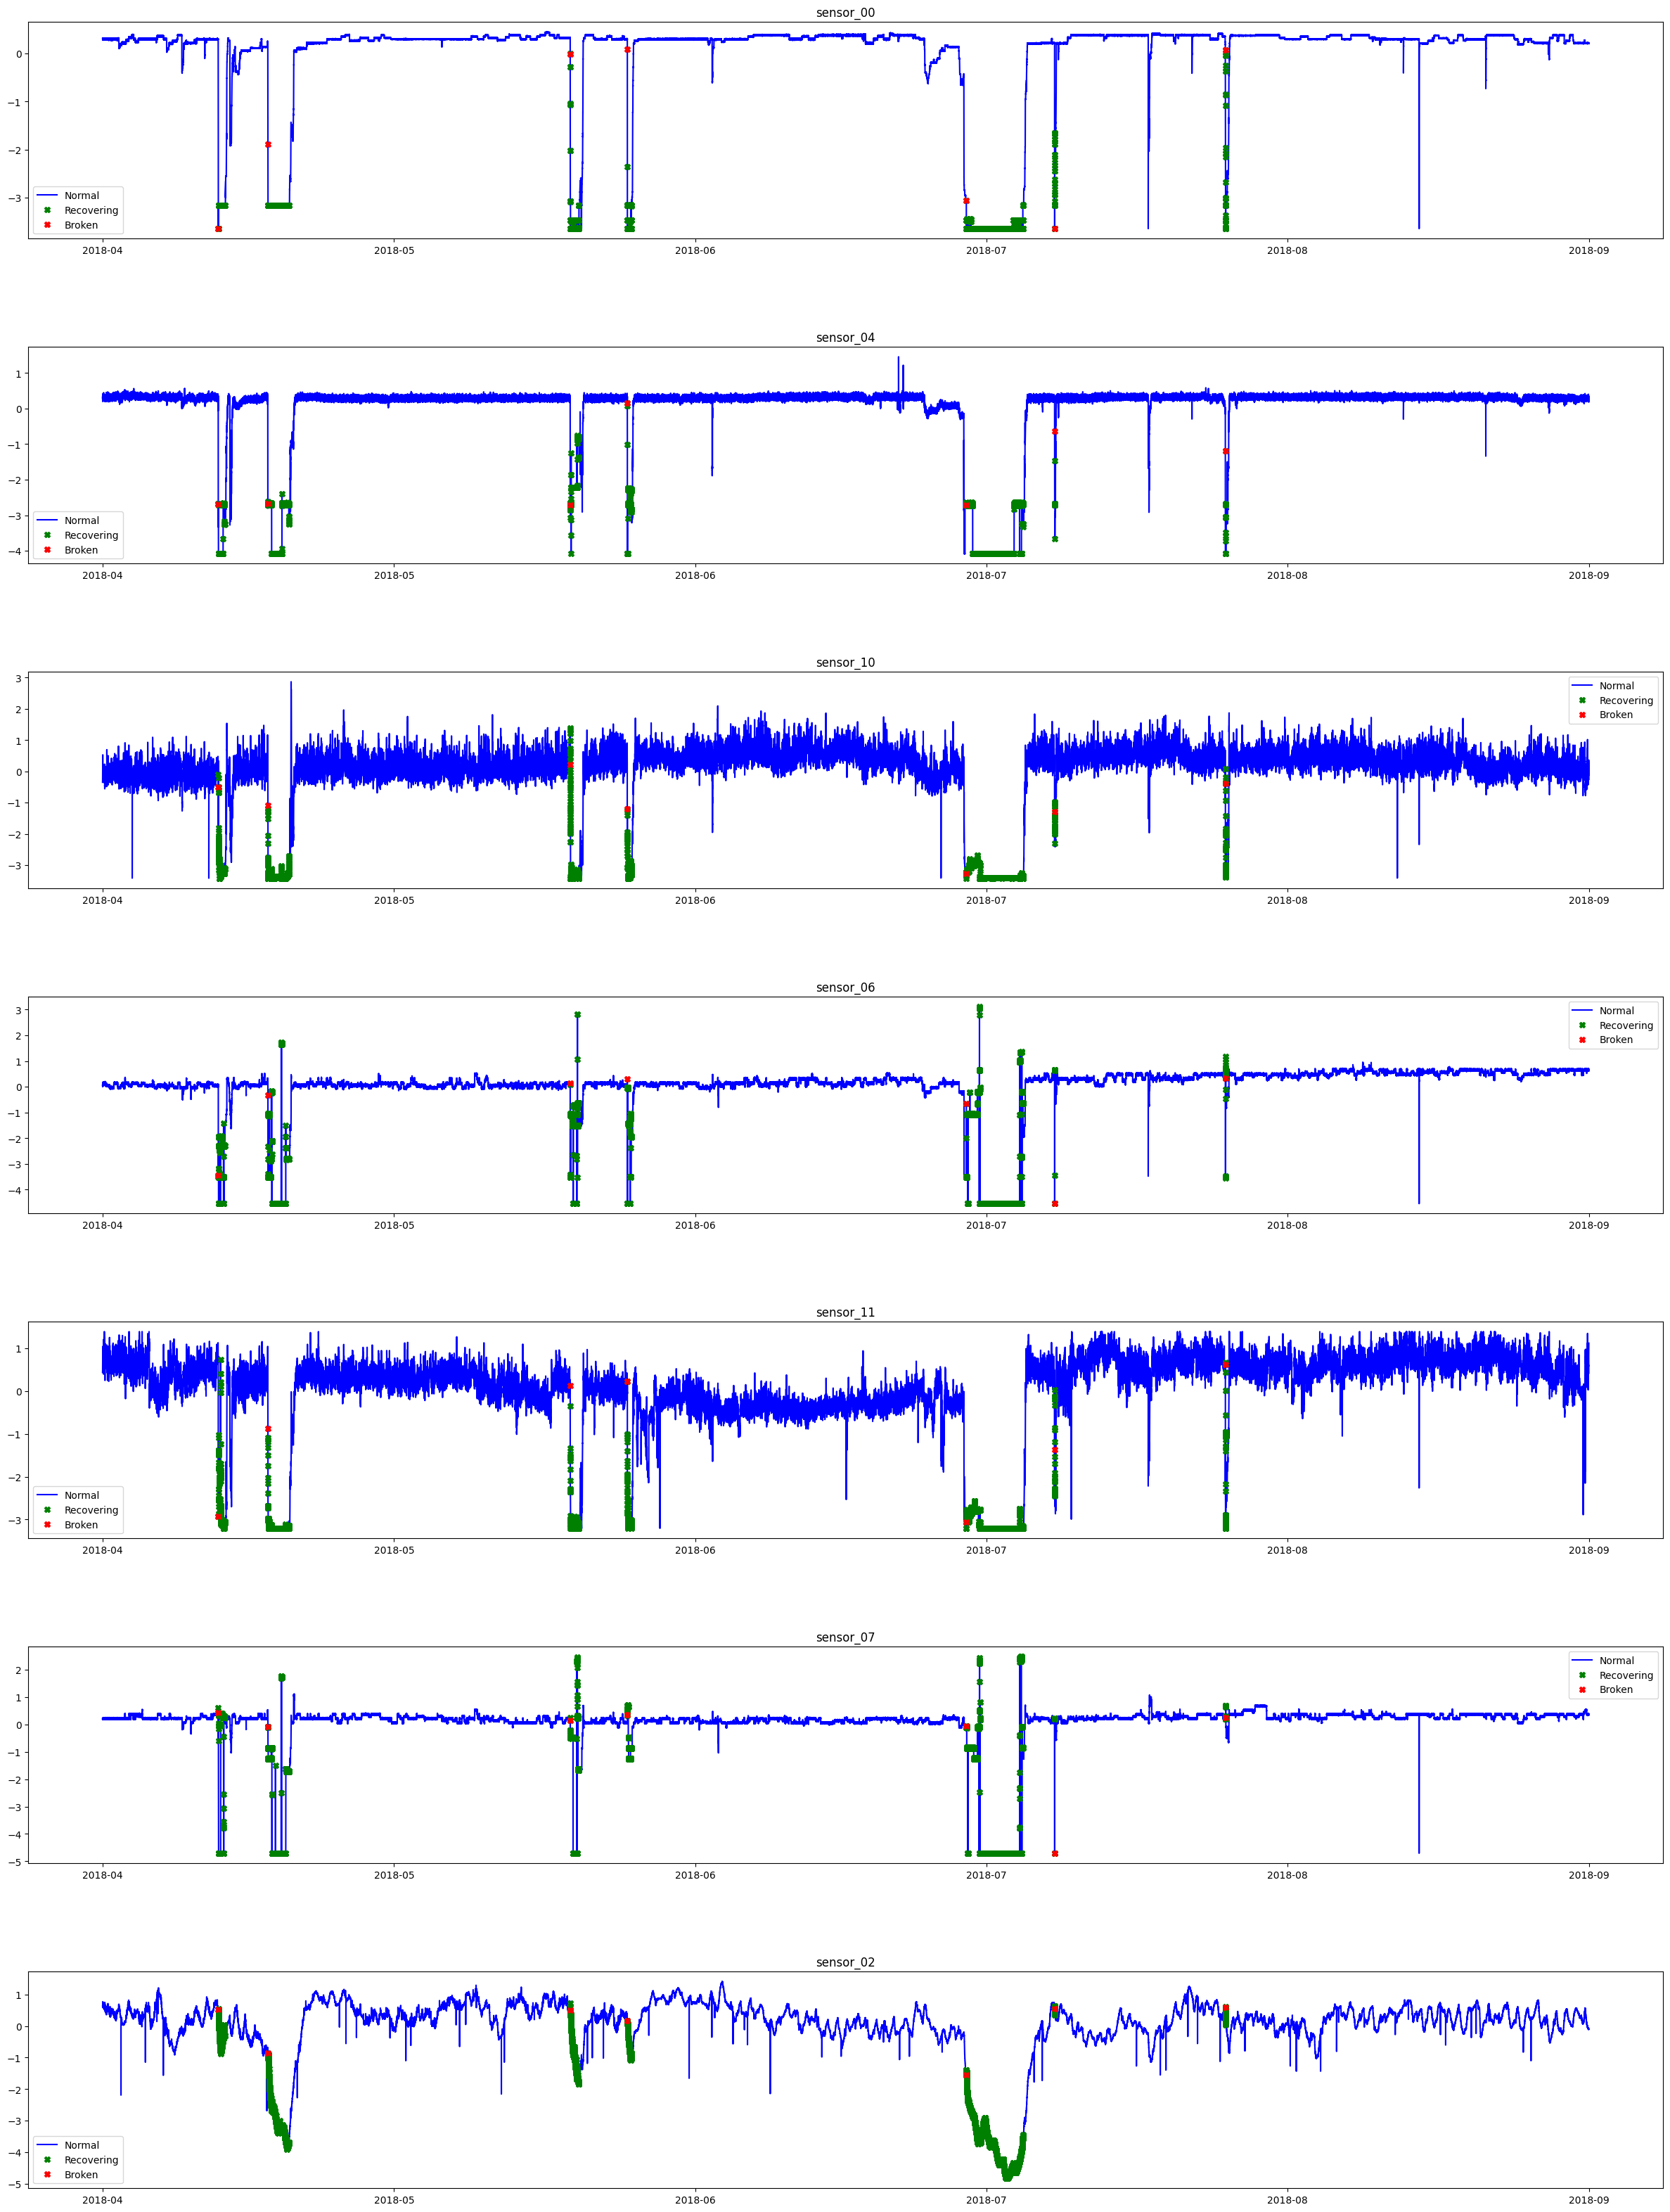

In [6]:
time_series_error_by_sensor(df,df_error,df_recovery,metric_columns)

## Isolation Forrest

In [7]:
# Split into training and test sets
cutoff_date = '2018-06-30'

In [8]:
df_if = detect_anomalies(df,metric_columns)

df_anomalies = df_if[df_if['anomaly_isolationforest'] == 1]

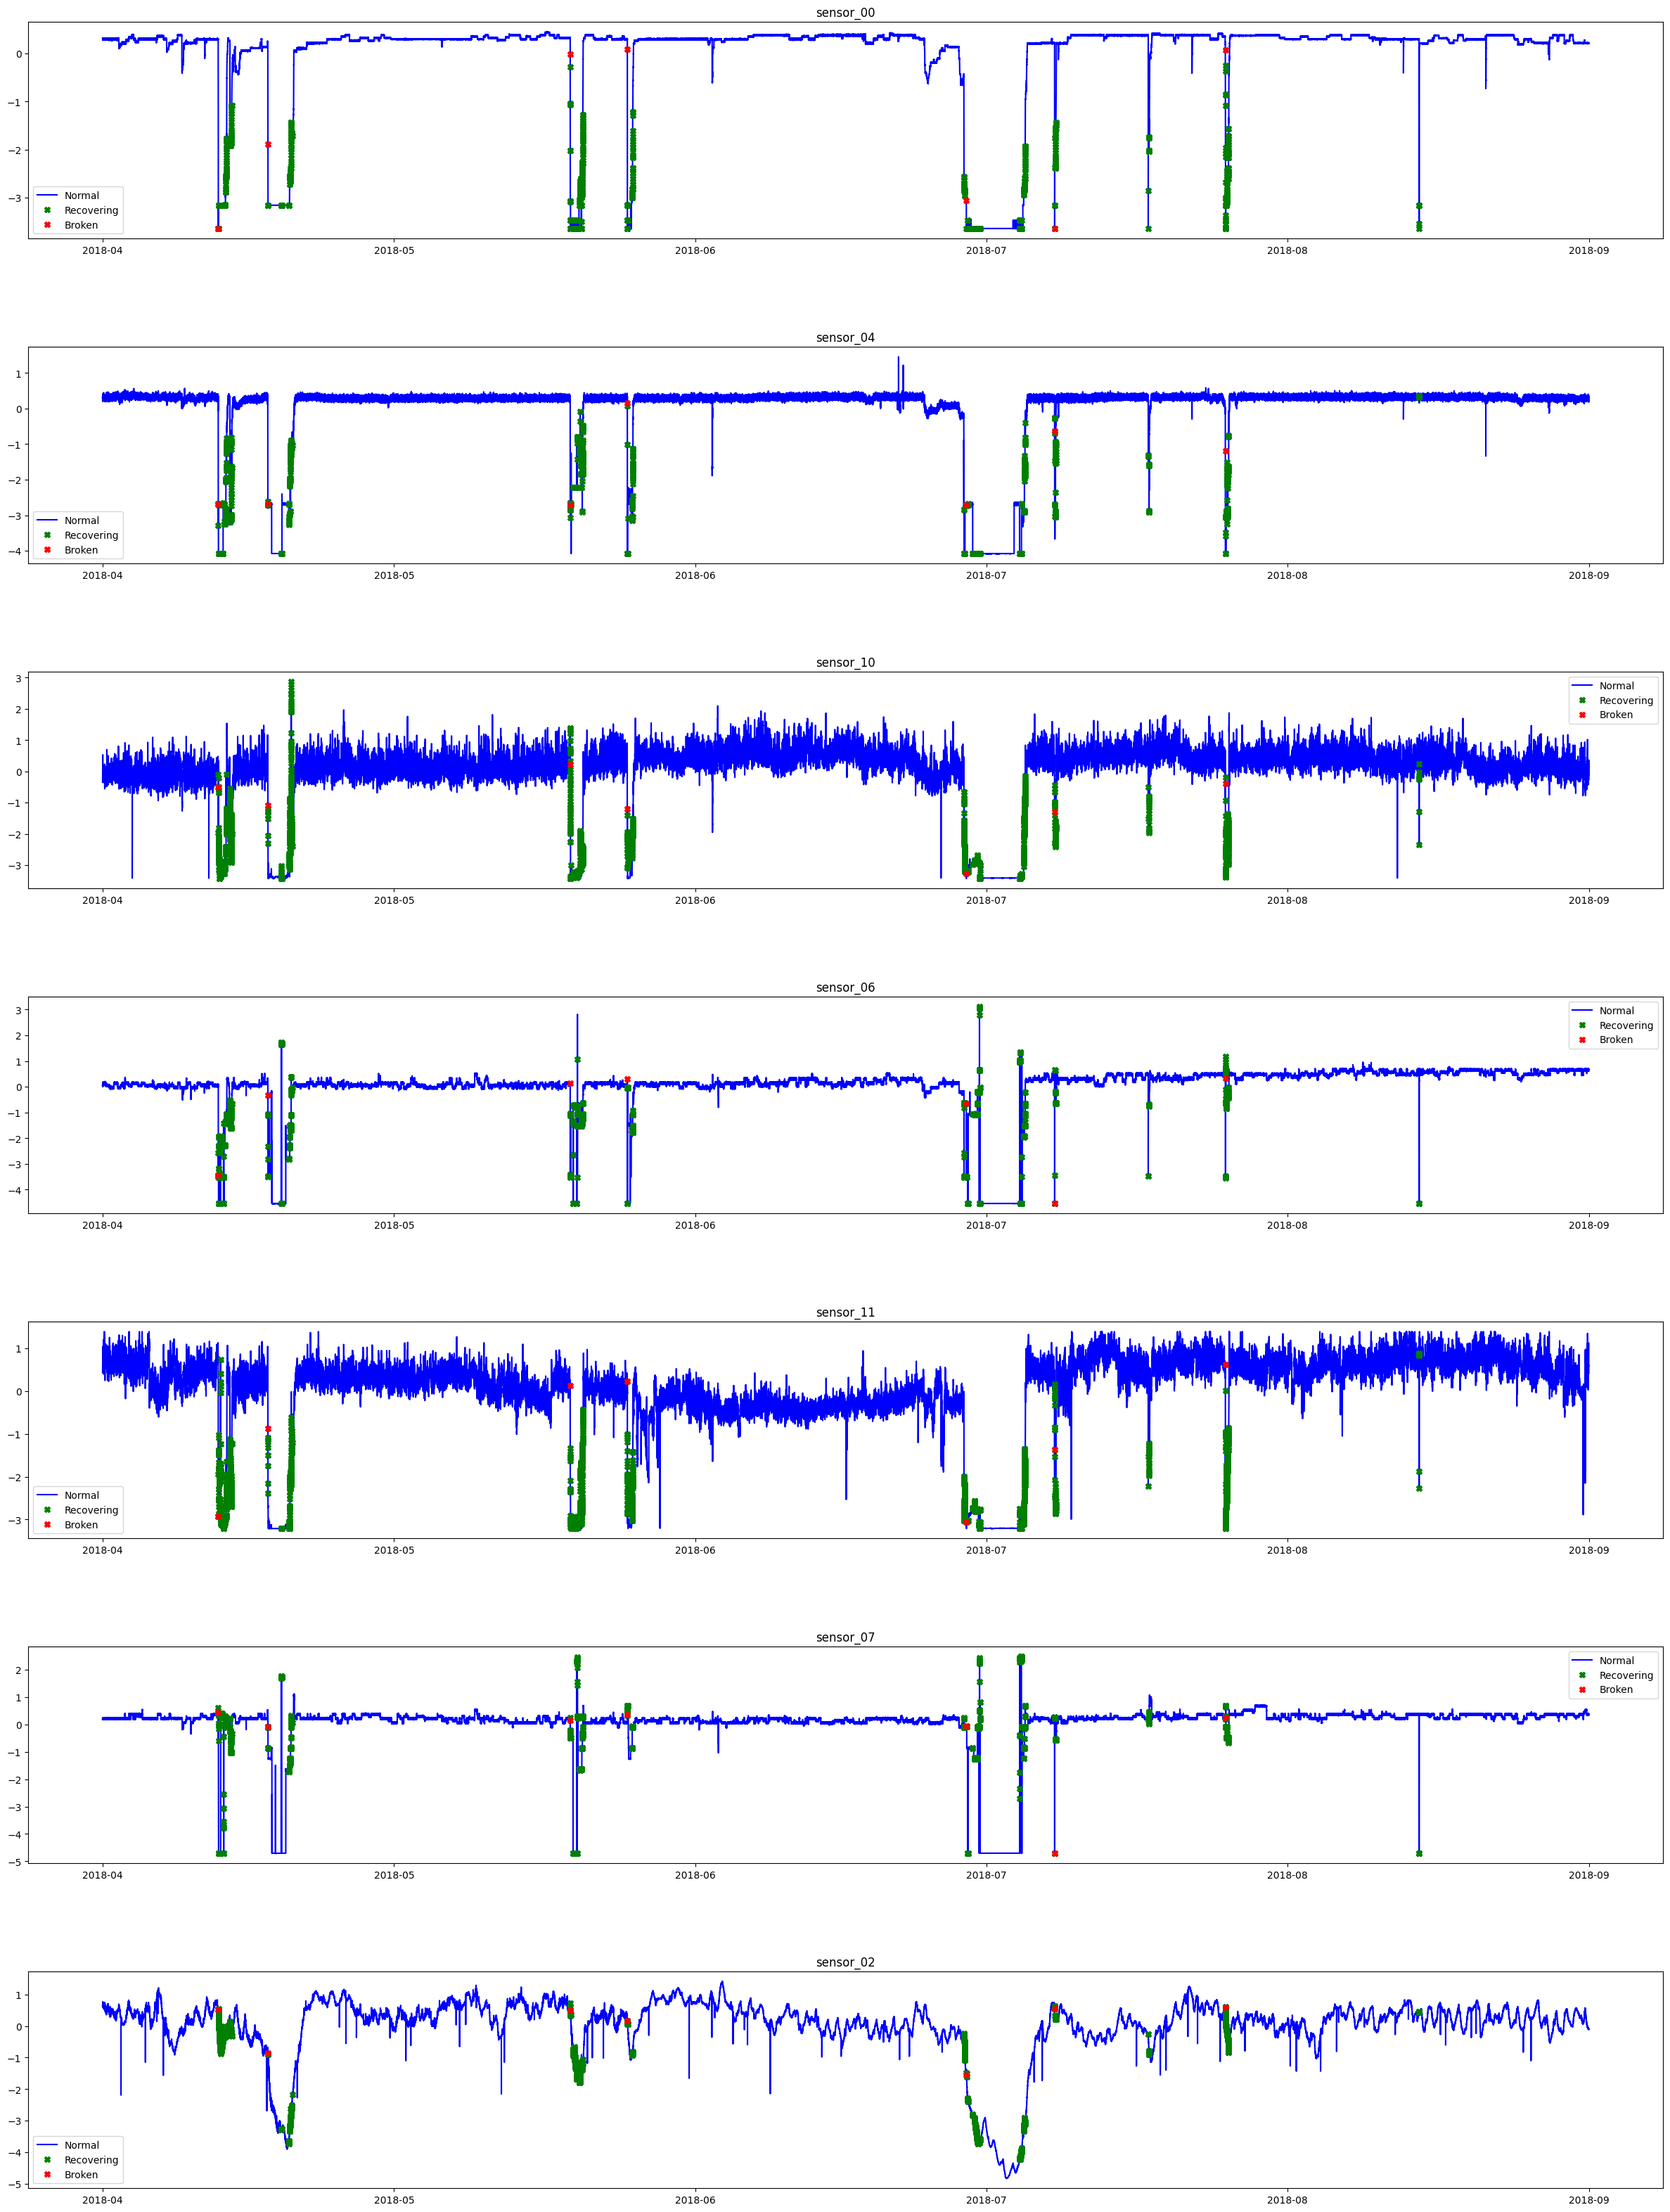

In [9]:
time_series_error_by_sensor(df,df_error,df_anomalies,metric_columns)

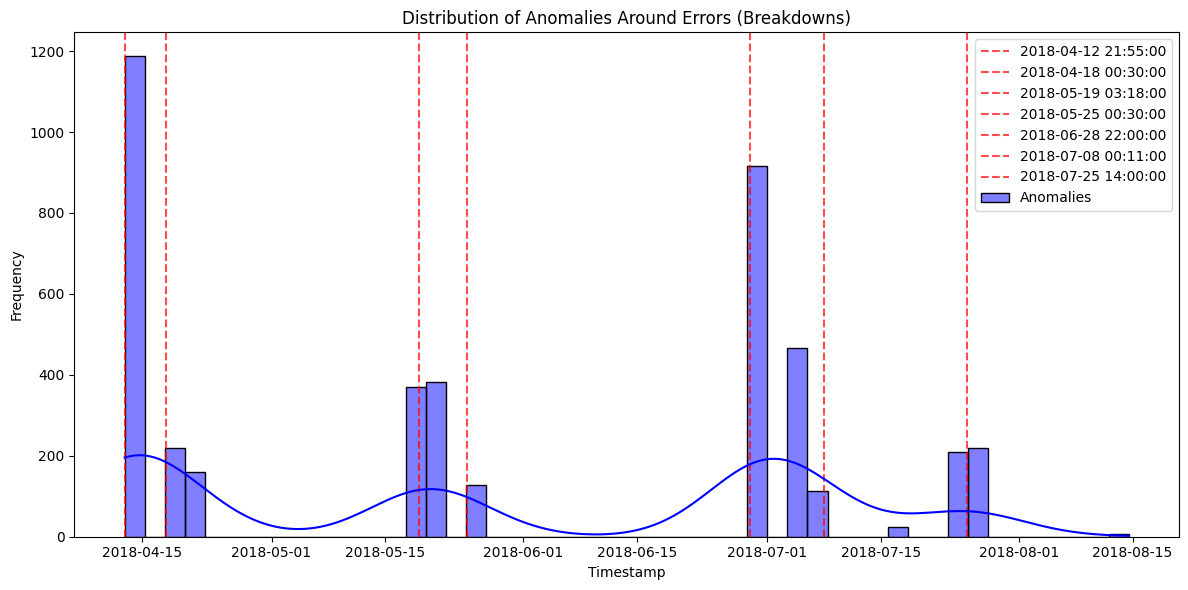

In [10]:
show_anomaly_distribution(df,df_anomalies,df_error)

### Autoencoder

In [11]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[metric_columns].values)

Epoch 1/50
2754/2754 [==============================] - 2s 748us/step - loss: 9.5378e-04 - val_loss: 6.3848e-05
Epoch 2/50
2754/2754 [==============================] - 2s 704us/step - loss: 3.9960e-05 - val_loss: 1.7493e-05
Epoch 3/50
2754/2754 [==============================] - 2s 895us/step - loss: 2.0516e-05 - val_loss: 3.0209e-05
Epoch 4/50
2754/2754 [==============================] - 2s 775us/step - loss: 1.5161e-05 - val_loss: 8.6379e-06
Epoch 5/50
2754/2754 [==============================] - 2s 731us/step - loss: 1.2424e-05 - val_loss: 9.1205e-06
Epoch 6/50
2754/2754 [==============================] - 2s 760us/step - loss: 1.0718e-05 - val_loss: 7.9606e-06
Epoch 7/50
2754/2754 [==============================] - 2s 750us/step - loss: 9.4247e-06 - val_loss: 4.9177e-06
Epoch 8/50
2754/2754 [==============================] - 2s 696us/step - loss: 8.7395e-06 - val_loss: 4.8273e-06
Epoch 9/50
2754/2754 [==============================] - 2s 733us/step - loss: 7.9344e-06 - val_loss: 5.8

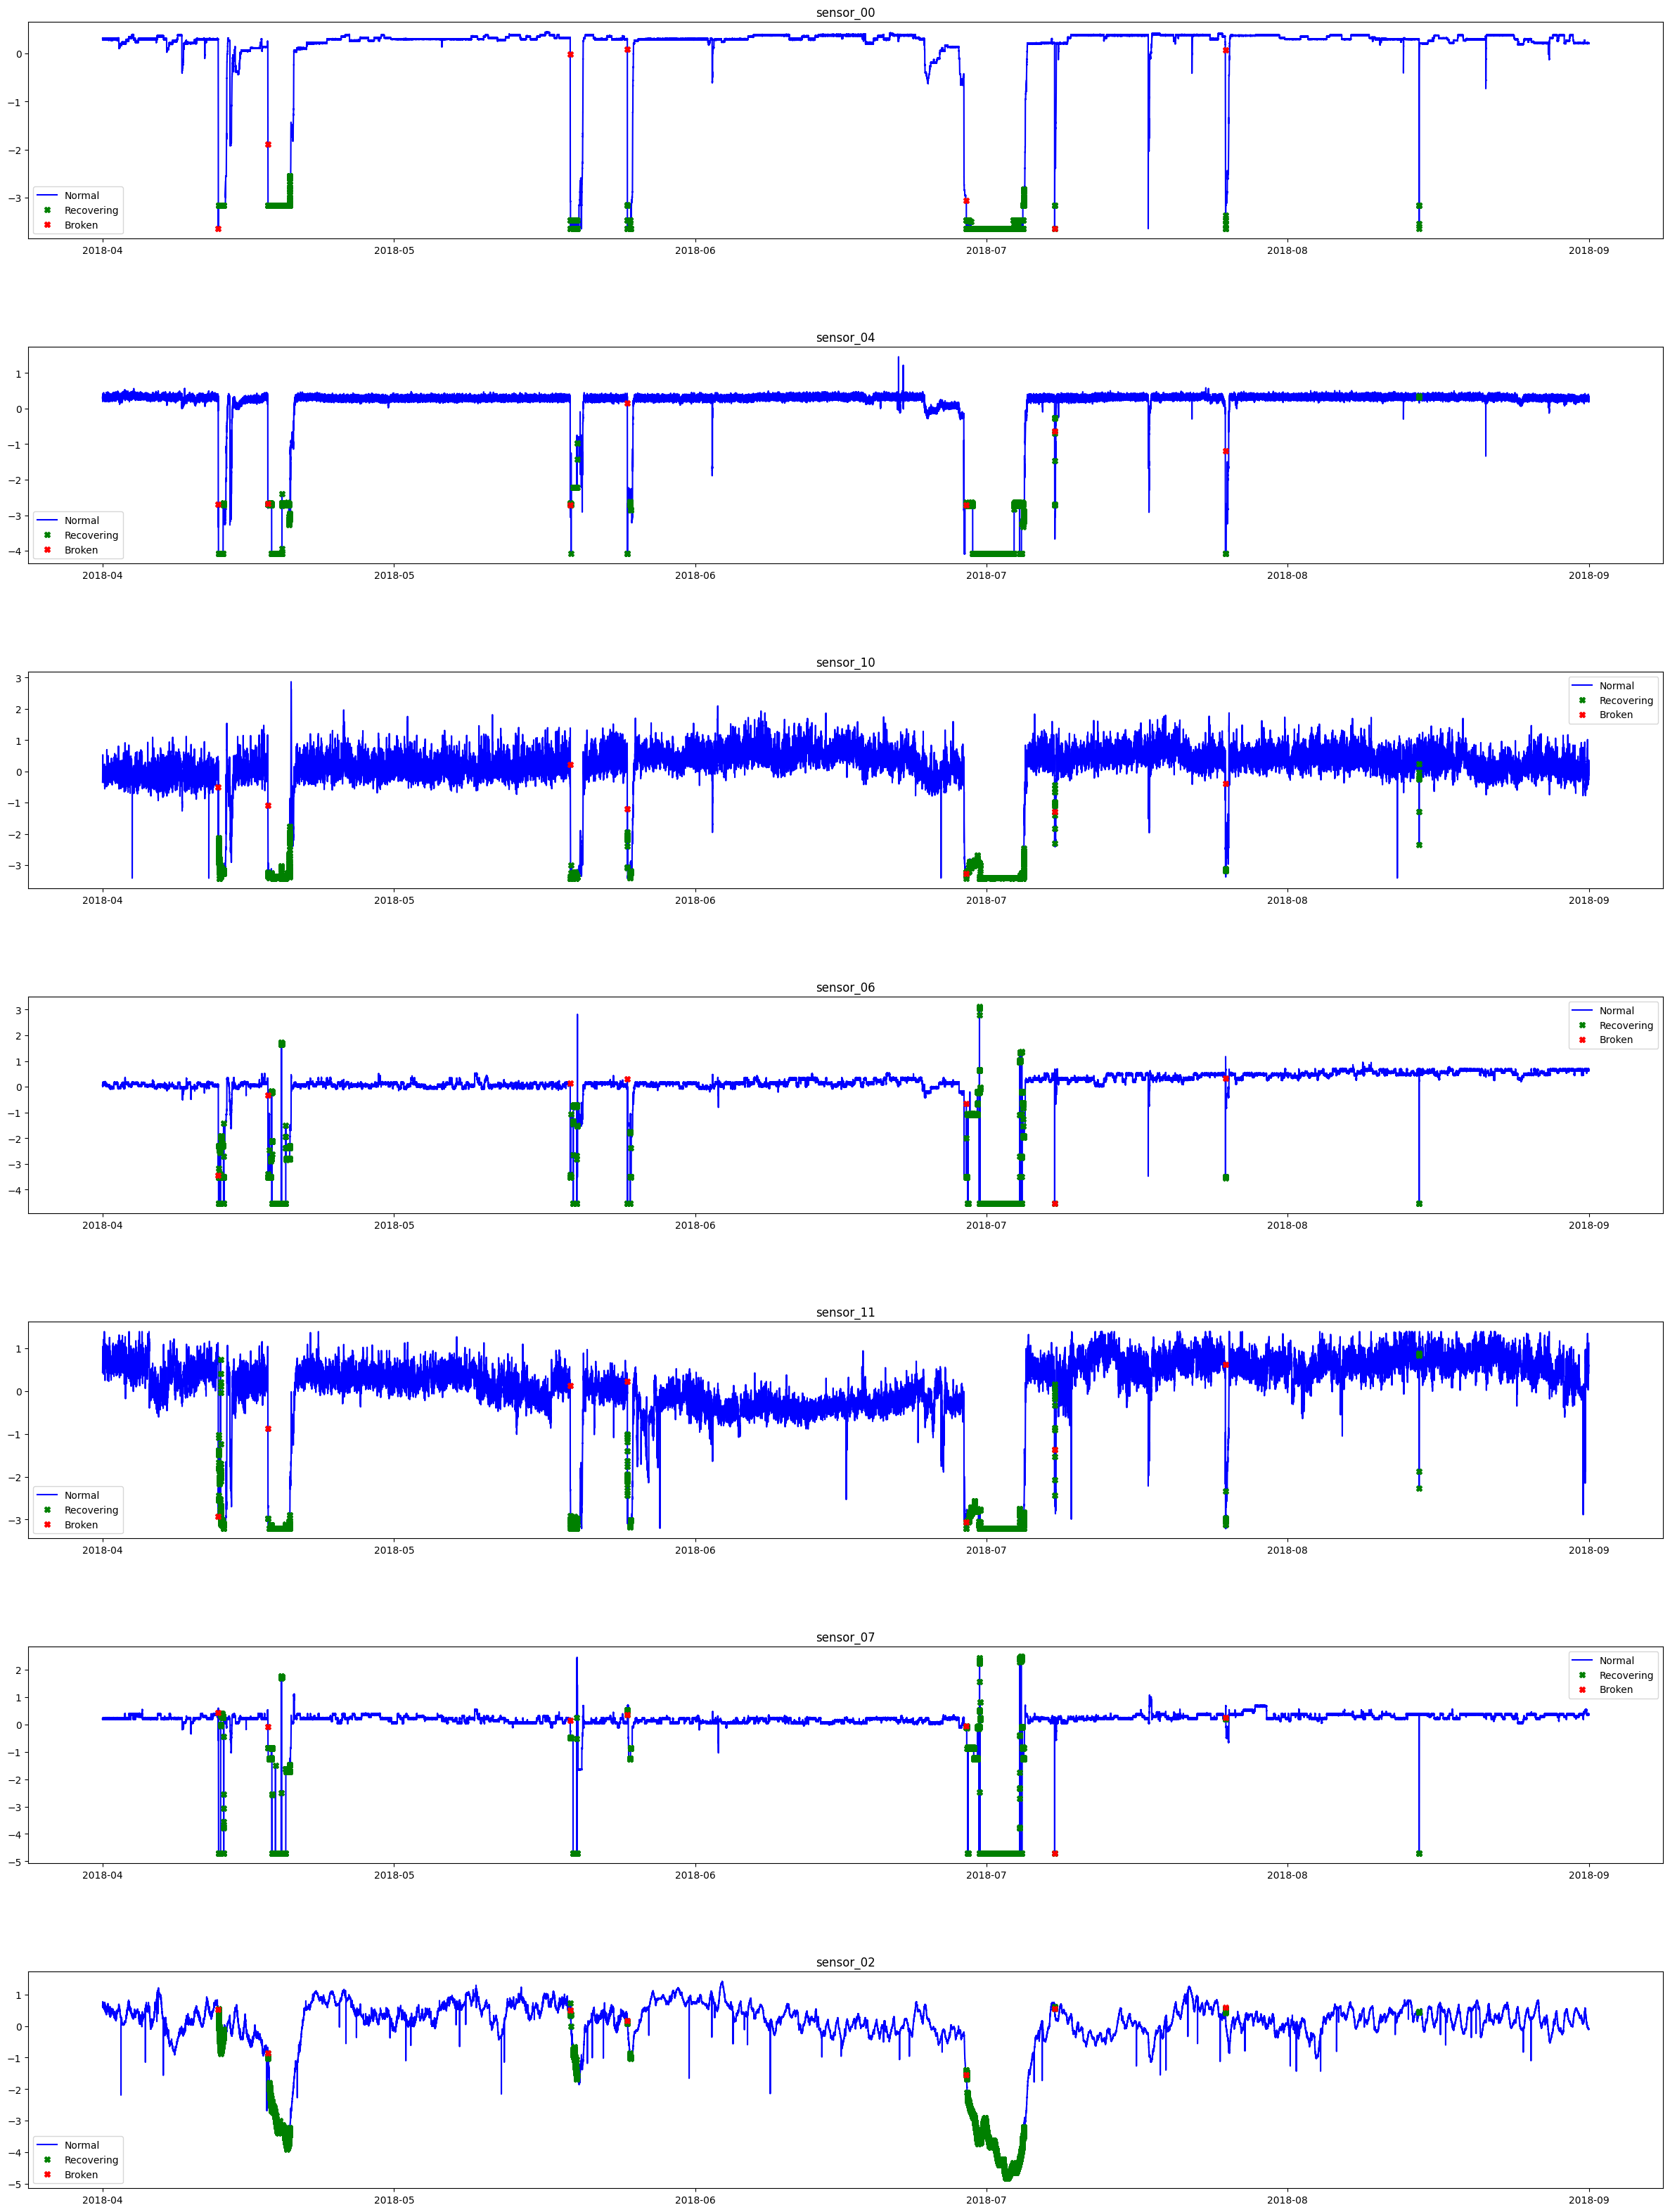

In [12]:
# Create and train the Autoencoder
autoencoder = create_autoencoder(X_scaled.shape[1])
autoencoder.fit(X_scaled,
                X_scaled, 
                epochs=50, 
                batch_size=64, 
                validation_split=0.2,
                verbose=1)

# Predict the reconstructed data
X_reconstructed = scaler.inverse_transform(autoencoder.predict(X_scaled))

# Calculate reconstruction error (MSE for each sample)
reconstruction_error = np.mean(np.square(X_scaled - X_reconstructed), axis=1)

# Use the 95th percentile of the reconstruction error as the anomaly threshold
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)

# Flag anomalies based on the reconstruction error exceeding the threshold
df['anomaly_autoencoder'] = (reconstruction_error > threshold).astype(int)

df_anomalies = df[df['anomaly_autoencoder'] == 1]

# Display the result
time_series_error_by_sensor(df,df_error,df_anomalies,metric_columns)

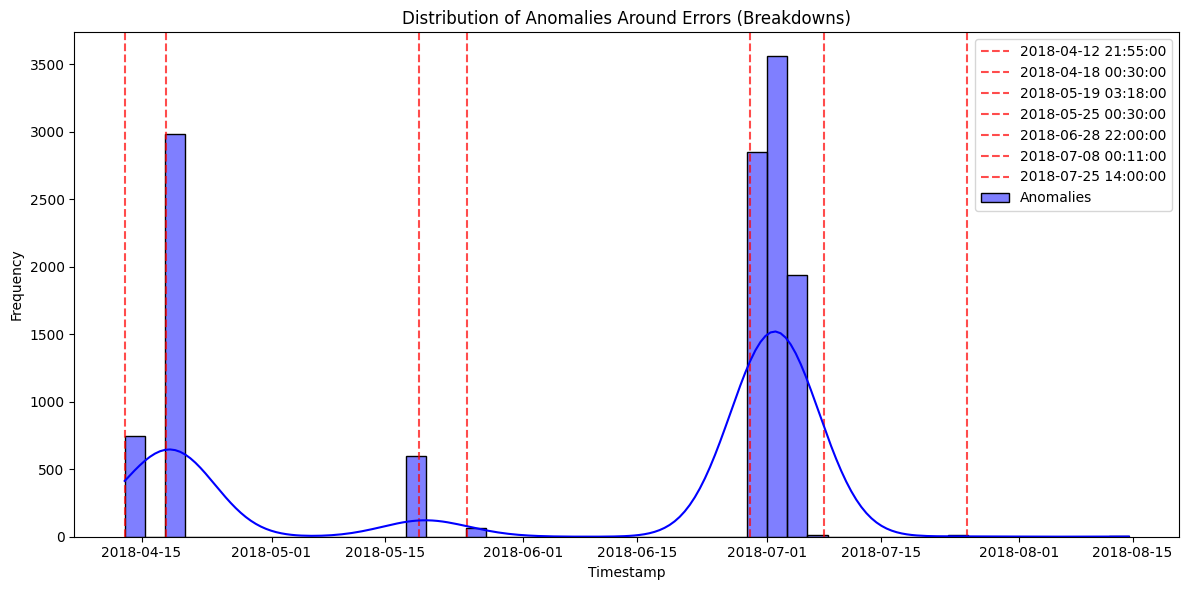

In [13]:
show_anomaly_distribution(df,df_anomalies,df_error)

### LSTM

In [14]:
timesteps = 10

In [15]:
# Create and train the LSTM autoencoder
X_lstm = np.array([X_scaled[i-timesteps:i] for i in range(timesteps, len(X_scaled))])

lstm_autoencoder = create_lstm_autoencoder(X_lstm.shape[1:])
lstm_autoencoder.fit(X_lstm, 
                     X_lstm, 
                     epochs=50, 
                     batch_size=64, 
                     validation_split=0.2, 
                     verbose=1)

# Predict reconstructed values
X_reconstructed = lstm_autoencoder.predict(X_lstm)

# Compute reconstruction error
reconstruction_error = np.mean(np.square(X_lstm - X_reconstructed), axis=(1,2))

# Set anomaly threshold
threshold = np.mean(reconstruction_error) + 1.5 * np.std(reconstruction_error)  # Fine tune by changing "2": the lower -> more sensitive, the higher -> less sensitive, more false positives

# Insert anomaly labels back into DataFrame
df_anomaly = df.iloc[timesteps:].copy()  # Align with reshaped dataset
df_anomaly['anomaly_lstm'] = (reconstruction_error > threshold).astype(int)

df_LSTM = df_anomaly[df_anomaly['anomaly_lstm'] == 1]

Epoch 1/50
2754/2754 [==============================] - 37s 13ms/step - loss: 0.0042 - val_loss: 0.0193
Epoch 2/50
2754/2754 [==============================] - 34s 13ms/step - loss: 9.2169e-04 - val_loss: 0.0223
Epoch 3/50
2754/2754 [==============================] - 35s 13ms/step - loss: 7.0401e-04 - val_loss: 0.0247
Epoch 4/50
2754/2754 [==============================] - 36s 13ms/step - loss: 6.0361e-04 - val_loss: 0.0246
Epoch 5/50
2754/2754 [==============================] - 34s 12ms/step - loss: 5.2567e-04 - val_loss: 0.0260
Epoch 6/50
2754/2754 [==============================] - 34s 12ms/step - loss: 4.8901e-04 - val_loss: 0.0323
Epoch 7/50
2754/2754 [==============================] - 34s 12ms/step - loss: 4.7120e-04 - val_loss: 0.0256
Epoch 8/50
2754/2754 [==============================] - 34s 12ms/step - loss: 4.3001e-04 - val_loss: 0.0290
Epoch 9/50
2754/2754 [==============================] - 34s 12ms/step - loss: 4.2063e-04 - val_loss: 0.0296
Epoch 10/50
2754/2754 [=========

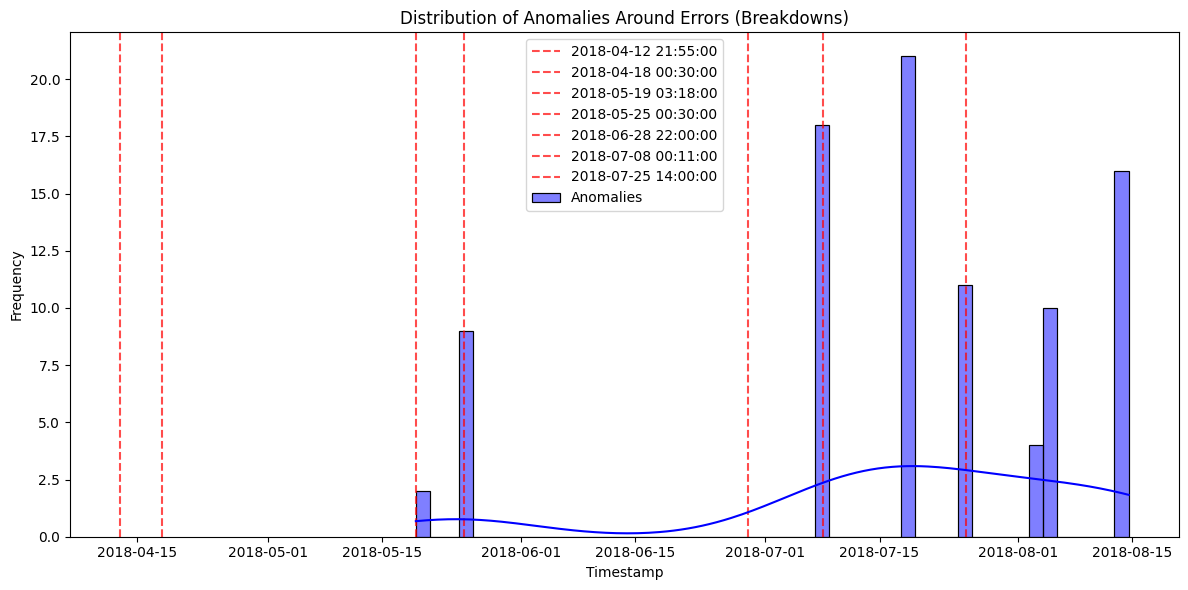

In [16]:
show_anomaly_distribution(df_anomaly,df_LSTM,df_error)

### Combine LSTM and Autoencoder

In [17]:
df_combined = df_anomaly.copy()

df_combined["anomaly_combined"] = ((df_anomaly["anomaly_lstm"] == 1) & 
                                   (df_anomaly["anomaly_autoencoder"] == 1)).astype(int)

In [18]:
df_combined['anomaly_score'] = (df_anomaly['anomaly_lstm'] * 0.5) + (df_anomaly['anomaly_autoencoder'] * 0.5)
df_combined_predict = df_combined[df_combined['anomaly_score'] > 0.4]


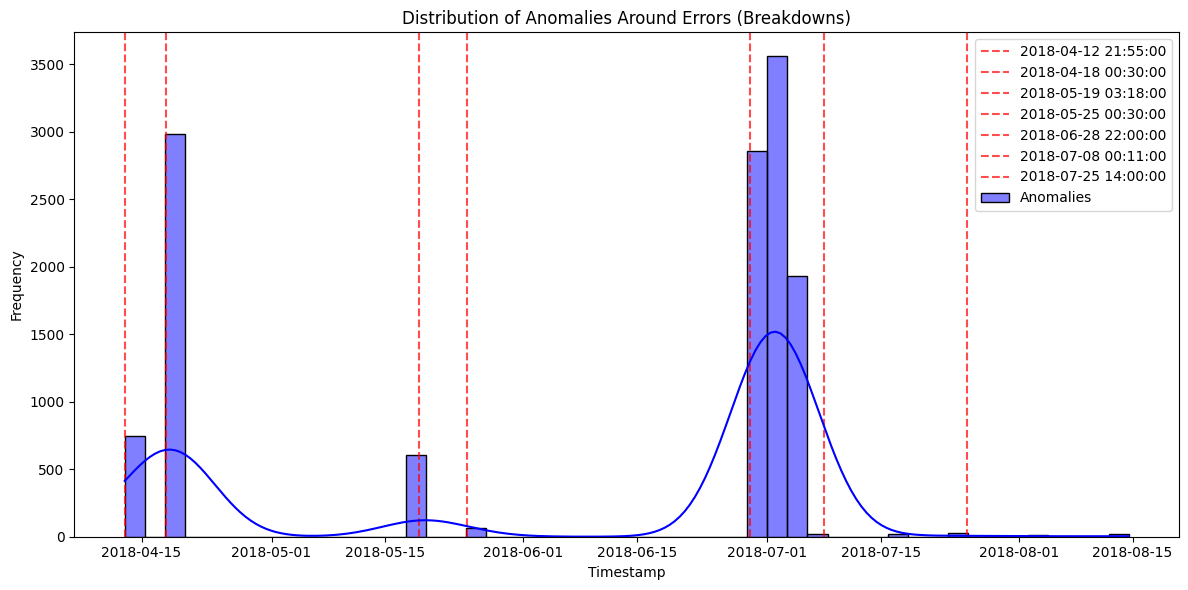

In [19]:
show_anomaly_distribution(df,df_combined_predict,df_error)